In [1]:
from __future__ import print_function
from __future__ import division
import os
import cPickle as pickle
import json
import subprocess
from IPython.display import display
from IPython.display import Audio
import bisect
from collections import namedtuple
import numpy as np
import pandas as pd
from collections import Counter
from prettytable import PrettyTable
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate
from matplotlib.ticker import MultipleLocator, \
     FormatStrFormatter, AutoMinorLocator
%matplotlib inline

In [2]:
with open("config.json") as json_data_file:
    config = json.load(json_data_file)

In [3]:
nodes_fname = config["es"]['nodes_fname']
seg_nodes_fname = config["es"]['seg_nodes_fname']
nodes_dict_fname = config["es"]['nodes_dict_fname']

edges_utd_fname = config["es"]['edges_utd_fname']
edges_olap_fname = config["es"]['edges_olap_fname']
edges_all_fname = config["es"]['edges_all_fname']
edges_score_fname = config["es"]['edges_score_fname']

clusters_utd_fname = config['es']['clusters_utd_fname']
clusters_fname = config['es']['clusters_fname']
clusters_stats_fname = config['es']['clusters_stats_fname']

pairs_fname = config['es']['score_pairs_fname']
eval_fname = config['es']['eval_pairs_fname']

feats_fname = config['es']['feats_fname']

# Gold feats
gold_feats_dict_fname = config['es']['gold_feats']
# Pseudo feats
feats_dict_fname = config['es']['feats_dict_fname']

gold_probs_fname = config['es']['mt_probs_gold']
gold_probs_dict_fname = config['es']['mt_probs_dict_gold']

pseudo_probs_fname = config['es']['mt_probs_pseudo']
pseudo_probs_dict_fname = config['es']['mt_probs_dict_pseudo']

train_segment_list_fname = config['es']['mt_train_files']
dev_segment_list_fname = config['es']['mt_dev_files']

gold_corpus_fname = config['es']['mt_corpus_train_gold']
pseudo_corpus_fname = config['es']['mt_corpus_train_pseudo']

mt_gold_pred_dict_fname = config['es']['mt_gold_pred_dict']
mt_pseudo_pred_dict_fname = config['es']['mt_pseudo_pred_dict']

mt_gold_eval_dict_fname = config['es']['mt_gold_eval_dict']
mt_pseudo_eval_dict_fname = config['es']['mt_pseudo_eval_dict']

has_500ms_fa_vad_dict_fname = config['es']['has_500ms_fa_vad_dict']

In [4]:
Align = namedtuple('Align', ['word', 'start', 'end'])
Node = namedtuple('Node', ['file', 'seg', 'start', 'end', 'es', 'es_cnt'])
Eval = namedtuple('Eval', ['n1', 'n2', 'dtw', 'es_sim', 'es_cnt_sim', 'en_j_sim'])

In [5]:
segment_map = pickle.load(open(config['es']['segment_dict_fname'], "rb"))
align_dict = pickle.load(open(config['es']['align_dict_fname'], "rb"))
nodes_dict = pickle.load(open(nodes_dict_fname, "rb"))
pairs_list = pickle.load(open(pairs_fname, "rb"))
eval_dict = pickle.load(open(eval_fname, "rb"))
clusters = pickle.load(open(clusters_fname, "rb"))
clusters_stats = pickle.load(open(clusters_stats_fname, "rb"))
feats_dict = pickle.load(open(feats_dict_fname, "rb"))
gold_feats_dict = pickle.load(open(gold_feats_dict_fname, "rb"))

if os.path.exists(gold_probs_dict_fname):
    gold_probs_dict = pickle.load(open(gold_probs_dict_fname, "rb"))

if os.path.exists(pseudo_probs_dict_fname):
    pseudo_probs_dict = pickle.load(open(pseudo_probs_dict_fname, "rb"))

if os.path.exists(mt_gold_pred_dict_fname):
    mt_gold_pred_dict = pickle.load(open(mt_gold_pred_dict_fname, "rb"))
    
if os.path.exists(mt_pseudo_pred_dict_fname):
    mt_pseudo_pred_dict = pickle.load(open(mt_pseudo_pred_dict_fname, "rb"))
    
if os.path.exists(has_500ms_fa_vad_dict_fname):
    has_500ms_fa_vad_dict = pickle.load(open(has_500ms_fa_vad_dict_fname, "rb"))

# Create parallel corpus

- Use list of files specified for training
- Create golden parallel corpus, using es transcriptions
- Create pseudotext ||| english parallel corpus
- For English, filter for content words


In [6]:
# def create_parallel_corpus(segment_list_fname, corpus_fname, pseudotext=False, es_w_key='es', en_w_key='en'):
#     with open(corpus_fname, "w") as out_f, open(segment_list_fname) as in_f:
#         for seg_id in in_f:
#             seg_id = seg_id.strip()
#             if pseudotext:
#                 es_words = map(str, feats_dict[seg_id])
#             else:
#                 es_words = [w.word for w in align_dict[seg_id.split('.')[0]][seg_id][es_w_key]]
#                 if not es_words:
#                     es_words = ['-1']
            
#             en_words = [w.word for w in align_dict[seg_id.split('.')[0]][seg_id][en_w_key]]
#             if not en_words:
#                 en_words = [w.word for w in align_dict[seg_id.split('.')[0]][seg_id]['en']]
            
#             if es_words != ['-1']:
#                 outline = " ".join(es_words) + " ||| " + " ".join(en_words) + "\n"
#                 out_f.write(outline)
#     print("Finished generating MT corpus")
        

In [7]:
def get_en_words(align_dict, seg_id, en_key):
    en_words = [w.word for w in align_dict[seg_id.split('.')[0]][seg_id][en_key] if "'" not in w.word]
    if not en_words:
        en_words = [w.word for w in align_dict[seg_id.split('.')[0]][seg_id]['en'] if "'" not in w.word]
    return en_words

In [8]:
def create_parallel_corpus(segment_list_fname, corpus_fname, feats_dict, align_dict, en_w_key='en'):
    total_errors = 0
    with open(corpus_fname, "w") as out_f, open(segment_list_fname) as in_f:
        for seg_id in in_f:
            seg_id = seg_id.strip()
            es_words = feats_dict[seg_id]
            if not es_words:
                es_words = ['-1']
                print('Aha')
            
            en_words = get_en_words(align_dict, seg_id, en_w_key)
            
            if es_words != ['-1']:
                outline = " ".join(es_words) + " ||| " + " ".join(en_words) + "\n"
                out_f.write(outline)
            else:
                total_errors += 1
    print("Finished generating MT corpus")
    print("Not found for: %d utterances" % total_errors)

In [9]:
lol = [item for lst in feats_dict.values() for item in lst]
'-1' in map(str, lol[:10])
lol[:10]

['13201', '-1', '8020', '10962', '-1', '11200', '4102', '11128', '-1', '-1']

In [10]:
en_w_key = 'en_cnt'

In [11]:
create_parallel_corpus(train_segment_list_fname, gold_corpus_fname, gold_feats_dict, align_dict, en_w_key=en_w_key)

Finished generating MT corpus
Not found for: 0 utterances


In [12]:
create_parallel_corpus(train_segment_list_fname, pseudo_corpus_fname, feats_dict, align_dict, en_w_key=en_w_key)

Finished generating MT corpus
Not found for: 4093 utterances


# Train MT model using *fast_align*

In [13]:
def train_mt(corpus_fname, probs_fname):
    FASTALIGN = config['base']['fast_align']
    subprocess.call([FASTALIGN,"-i", corpus_fname, "-v", "-N", "-p", probs_fname]) 

In [14]:
train_mt(gold_corpus_fname, gold_probs_fname)

In [15]:
train_mt(pseudo_corpus_fname, pseudo_probs_fname)

In [16]:
def save_mt_probs(probs_fname, probs_dict_fname):
    probs_dict = {}
    with open(probs_fname, "r") as in_f:
        for i, line in enumerate(in_f):
            line_items = line.strip().split()
            es_w = line_items[0]
            if es_w not in probs_dict:
                probs_dict[es_w] = {}
            en_w = line_items[1]
            log_prob_val = float(line_items[2])
            probs_dict[es_w][en_w] = log_prob_val
    print("Finished reading mt probs file: %s" % os.path.basename(probs_fname))
    pickle.dump(probs_dict, open(probs_dict_fname, "wb"))
    print("Finished saving mt probs dictionary: %s" % os.path.basename(probs_dict_fname))
    return probs_dict
            

In [17]:
gold_probs_dict = save_mt_probs(gold_probs_fname, gold_probs_dict_fname)

Finished reading mt probs file: mt_probs_gold.txt
Finished saving mt probs dictionary: mt_probs_dict_gold.p


In [18]:
pseudo_probs_dict = save_mt_probs(pseudo_probs_fname, pseudo_probs_dict_fname)

Finished reading mt probs file: mt_probs_pseudo.txt
Finished saving mt probs dictionary: mt_probs_dict_pseudo.p


In [19]:
display(gold_probs_dict.keys()[:5])
display(pseudo_probs_dict.keys()[:5])
# pseudo_probs_dict['1869']

['JOHNNY', 'AGRADECIMIENTO', 'CATORCE', 'DILUY\xc3\xb3', 'ESPERO']

['4446', '4447', '11542', '11543', '11540']

# Make predictions

In [20]:
def mt_predict(feats_dict, probs_dict, k=1):
    missing_pwords_errors = 0
    missing_mt_errors = 0
    
    pred_dict = {}
    # Sort probs dict
    probs_dict_sorted = {k: sorted(v.items(), reverse=False, key=lambda t:t[1]) for k, v in probs_dict.items()}
    
    for seg_id in feats_dict:
        # Empty list to store predicted English words
        pred_dict[seg_id] = []
        es_words = feats_dict[seg_id]
        if es_words == ['-1']:
            missing_pwords_errors += 1
        else:
            for esw in es_words:
                # Get k predictions from probs dict
                if esw in probs_dict_sorted:
                    pred_dict[seg_id].extend([w for w,p in probs_dict_sorted[esw][:k]])
                else:
                    missing_mt_errors += 1
    print("Finished making predictions")
    print("pseudoword missing for: %d utterances, and translations missing for: %d" % (missing_pwords_errors, missing_mt_errors))
    return pred_dict

In [21]:
mt_gold_pred_dict = {}
for k in xrange(1,11):
    print('\nGenerating k=%d predictions' % k)
    mt_gold_pred_dict[k] = mt_predict(gold_feats_dict, gold_probs_dict, k=k)

pickle.dump(mt_gold_pred_dict, open(mt_gold_pred_dict_fname, "wb"))


Generating k=1 predictions
Finished making predictions
pseudoword missing for: 0 utterances, and translations missing for: 6326

Generating k=2 predictions
Finished making predictions
pseudoword missing for: 0 utterances, and translations missing for: 6326

Generating k=3 predictions
Finished making predictions
pseudoword missing for: 0 utterances, and translations missing for: 6326

Generating k=4 predictions
Finished making predictions
pseudoword missing for: 0 utterances, and translations missing for: 6326

Generating k=5 predictions
Finished making predictions
pseudoword missing for: 0 utterances, and translations missing for: 6326

Generating k=6 predictions
Finished making predictions
pseudoword missing for: 0 utterances, and translations missing for: 6326

Generating k=7 predictions
Finished making predictions
pseudoword missing for: 0 utterances, and translations missing for: 6326

Generating k=8 predictions
Finished making predictions
pseudoword missing for: 0 utterances, and

In [22]:
mt_pseudo_pred_dict = {}
for k in xrange(1,11):
    print('\nGenerating k=%d predictions' % k)
    mt_pseudo_pred_dict[k] = mt_predict(feats_dict, pseudo_probs_dict, k=k)

pickle.dump(mt_pseudo_pred_dict, open(mt_pseudo_pred_dict_fname, "wb"))


Generating k=1 predictions
Finished making predictions
pseudoword missing for: 8896 utterances, and translations missing for: 10403

Generating k=2 predictions
Finished making predictions
pseudoword missing for: 8896 utterances, and translations missing for: 10403

Generating k=3 predictions
Finished making predictions
pseudoword missing for: 8896 utterances, and translations missing for: 10403

Generating k=4 predictions
Finished making predictions
pseudoword missing for: 8896 utterances, and translations missing for: 10403

Generating k=5 predictions
Finished making predictions
pseudoword missing for: 8896 utterances, and translations missing for: 10403

Generating k=6 predictions
Finished making predictions
pseudoword missing for: 8896 utterances, and translations missing for: 10403

Generating k=7 predictions
Finished making predictions
pseudoword missing for: 8896 utterances, and translations missing for: 10403

Generating k=8 predictions
Finished making predictions
pseudoword mi

# Evaluation - Precision and Recall at *k*

In [23]:
def count_match(list1, list2):
    # each list can have repeated elements. The count should account for this.
    count1 = Counter(list1)
    count2 = Counter(list2)
    common_w = set(count1.keys()) & set(count2.keys())
    #all_w = set(count1.keys()) + set(count2.keys())
    matches = sum([min(count1[w], count2[w]) for w in common_w])
    return matches
#     for w in all_w:
#         if w in common_w:
#     print(count1, count2)

In [24]:
def eval_mt(segment_list_fname, pred_dict, align_dict, en_key='en'):
    # Get the k value from the prediction dict
    k = pred_dict.keys()
    # For every k value and for every segment, count
    #    tp - total predicted
    #    cp - correctly predicted
    #    t - total correct
    mt_eval_dict = {i: {'tp':0, 'cp':0, 't':0} for i in k}
    
    # Read segment ids to evaluate
    with open(segment_list_fname, "r") as seg_f:
        segids = set([sid.strip() for sid in seg_f if sid.strip()])
    
    print("evaluating %d segments" % len(segids))
    missing_preds = set()
    
    for i in k:
        print("Evaluating at k=%d" % i)
        #for sid in pred_dict[i]:
        for sid in segids:
            mt_eval_dict[i][sid] = {'tp':0, 'cp':0, 't':0}
            # get predicted words
            pred_en_words = pred_dict[i][sid]
            if len(pred_en_words) == 0:
                missing_preds |= set([sid])
            # get reference english words
            ref_en_words = get_en_words(align_dict, sid, en_key)
            mt_eval_dict[i][sid]['tp'] = len(pred_en_words)
            mt_eval_dict[i][sid]['cp'] = count_match(pred_en_words, ref_en_words)
            mt_eval_dict[i][sid]['t'] = len(ref_en_words)

            for count_key in ['tp', 'cp', 't']:
                mt_eval_dict[i][count_key] += mt_eval_dict[i][sid][count_key]
        # for segment ids
        # compute precision recall at every i
        mt_eval_dict[i]['precision'] = 0 if mt_eval_dict[i]['tp'] == 0 else \
                                    mt_eval_dict[i]['cp'] / mt_eval_dict[i]['tp']
        mt_eval_dict[i]['recall'] = mt_eval_dict[i]['cp'] / mt_eval_dict[i]['t']
    # for i in k predicts
    return mt_eval_dict, missing_preds

In [25]:
gold_mt_eval_dict = {}
gold_mt_eval_dict['train'], _ = eval_mt(train_segment_list_fname, mt_gold_pred_dict, align_dict, en_key=en_w_key)
gold_mt_eval_dict['dev'], _ = eval_mt(dev_segment_list_fname, mt_gold_pred_dict, align_dict, en_key=en_w_key)
pickle.dump(gold_mt_eval_dict, open(mt_gold_eval_dict_fname, "wb"))

evaluating 8055 segments
Evaluating at k=1
Evaluating at k=2
Evaluating at k=3
Evaluating at k=4
Evaluating at k=5
Evaluating at k=6
Evaluating at k=7
Evaluating at k=8
Evaluating at k=9
Evaluating at k=10
evaluating 911 segments
Evaluating at k=1
Evaluating at k=2
Evaluating at k=3
Evaluating at k=4
Evaluating at k=5
Evaluating at k=6
Evaluating at k=7
Evaluating at k=8
Evaluating at k=9
Evaluating at k=10


In [26]:
pseudo_mt_eval_dict = {}
pseudo_mt_eval_dict['train'], train_missing = eval_mt(train_segment_list_fname, mt_pseudo_pred_dict, align_dict, en_key=en_w_key)
pseudo_mt_eval_dict['dev'], dev_missing = eval_mt(dev_segment_list_fname, mt_pseudo_pred_dict, align_dict, en_key=en_w_key)
pickle.dump(pseudo_mt_eval_dict, open(mt_pseudo_eval_dict_fname, "wb"))

evaluating 8055 segments
Evaluating at k=1
Evaluating at k=2
Evaluating at k=3
Evaluating at k=4
Evaluating at k=5
Evaluating at k=6
Evaluating at k=7
Evaluating at k=8
Evaluating at k=9
Evaluating at k=10
evaluating 911 segments
Evaluating at k=1
Evaluating at k=2
Evaluating at k=3
Evaluating at k=4
Evaluating at k=5
Evaluating at k=6
Evaluating at k=7
Evaluating at k=8
Evaluating at k=9
Evaluating at k=10


In [27]:
dev_500ms_fname = config['es']['mt_dev_500ms_files']
pseudo_mt_500ms_eval_dict = {}
pseudo_mt_500ms_eval_dict['train'], train_missing = eval_mt(train_segment_list_fname, mt_pseudo_pred_dict, align_dict, en_key=en_w_key)
pseudo_mt_500ms_eval_dict['dev'], dev_missing = eval_mt(dev_500ms_fname, mt_pseudo_pred_dict, align_dict, en_key=en_w_key)

evaluating 8055 segments
Evaluating at k=1
Evaluating at k=2
Evaluating at k=3
Evaluating at k=4
Evaluating at k=5
Evaluating at k=6
Evaluating at k=7
Evaluating at k=8
Evaluating at k=9
Evaluating at k=10
evaluating 3587 segments
Evaluating at k=1
Evaluating at k=2
Evaluating at k=3
Evaluating at k=4
Evaluating at k=5
Evaluating at k=6
Evaluating at k=7
Evaluating at k=8
Evaluating at k=9
Evaluating at k=10


In [28]:
print(len(train_missing), len(dev_missing))
dev_missing_500ms = set([f for f, d in has_500ms_fa_vad_dict.items() if not d]) & dev_missing
print(len(dev_missing_500ms))
!wc $dev_segment_list_fname
!wc $train_segment_list_fname

4093 2011
0
 911  911 7288 ../files-dev-calls-63-120-10.txt
 8055  8055 64440 ../files-train-calls-63-120-10.txt


gold call train prec.: 0.4753, 0.4105, 0.3692, 0.3399, 0.3168, 0.2981, 0.2828, 0.2703, 0.2595, 0.2505
gold call train rec.:0.4704, 0.6376, 0.7178, 0.7617, 0.7896, 0.8078, 0.8211, 0.8330, 0.8428, 0.8504
gold call dev prec.: 0.3566, 0.3063, 0.2699, 0.2469, 0.2307, 0.2166, 0.2076, 0.1979, 0.1922, 0.1872
gold call dev rec.:0.2834, 0.3795, 0.4177, 0.4434, 0.4641, 0.4762, 0.4900, 0.4965, 0.5093, 0.5184


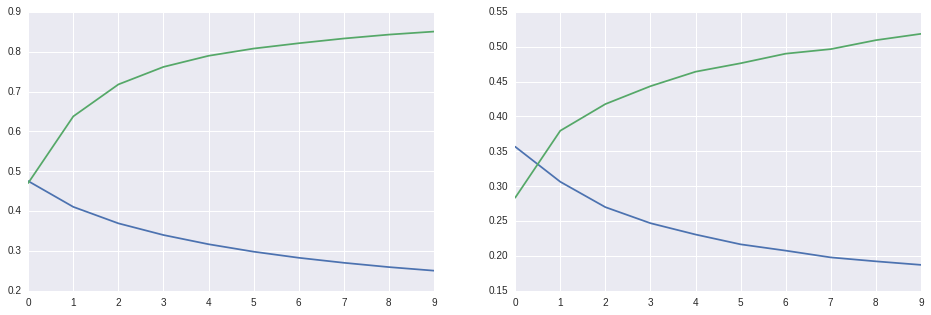

In [29]:
# plot precision, recall at i
fig = plt.figure(figsize=(16,5))
fig.add_subplot(121)
p_at_k = [gold_mt_eval_dict['train'][i]['precision'] for i in gold_mt_eval_dict['train']]
r_at_k = [gold_mt_eval_dict['train'][i]['recall'] for i in gold_mt_eval_dict['train']]
print("gold call train prec.: " + ", ".join(map(lambda v: "%.4f"%v, p_at_k)))
print("gold call train rec.:" + ", ".join(map(lambda v: "%.4f"%v, r_at_k)))
plt.plot(p_at_k)
plt.plot(r_at_k)
fig.add_subplot(122)
p_at_k = [gold_mt_eval_dict['dev'][i]['precision'] for i in gold_mt_eval_dict['dev']]
r_at_k = [gold_mt_eval_dict['dev'][i]['recall'] for i in gold_mt_eval_dict['dev']]
plt.plot(p_at_k)
plt.plot(r_at_k)
print("gold call dev prec.: " + ", ".join(map(lambda v: "%.4f"%v, p_at_k)))
print("gold call dev rec.:" + ", ".join(map(lambda v: "%.4f"%v, r_at_k)))

pseudo call train prec.: 0.4223, 0.3880, 0.3668, 0.3498, 0.3349, 0.3220, 0.3104, 0.2995, 0.2895, 0.2812
pseudo call train rec.:0.1854, 0.3042, 0.3949, 0.4657, 0.5184, 0.5589, 0.5891, 0.6104, 0.6262, 0.6386
pseudo call dev prec.: 0.0385, 0.0334, 0.0292, 0.0277, 0.0273, 0.0267, 0.0254, 0.0247, 0.0252, 0.0257
pseudo call dev rec.:0.0056, 0.0091, 0.0112, 0.0133, 0.0154, 0.0170, 0.0177, 0.0184, 0.0198, 0.0210


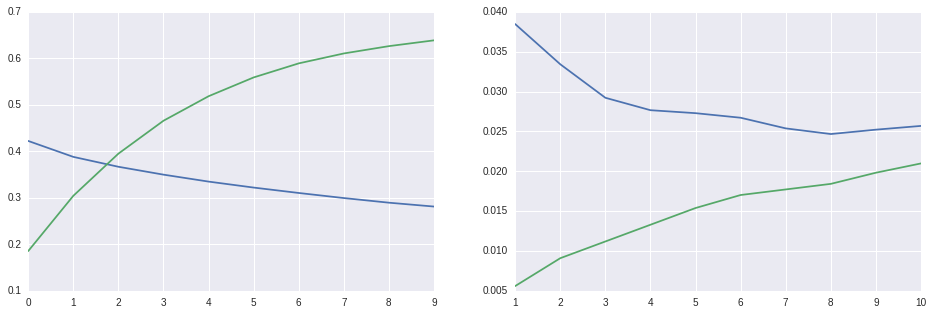

In [30]:
# plot precision, recall at i
fig = plt.figure(figsize=(16,5))
ax_1 = fig.add_subplot(121)
p_at_k = [pseudo_mt_eval_dict['train'][i]['precision'] for i in pseudo_mt_eval_dict['train']]
r_at_k = [pseudo_mt_eval_dict['train'][i]['recall'] for i in pseudo_mt_eval_dict['train']]
print("pseudo call train prec.: " + ", ".join(map(lambda v: "%.4f"%v, p_at_k)))
print("pseudo call train rec.:" + ", ".join(map(lambda v: "%.4f"%v, r_at_k)))
plt.plot(p_at_k)
plt.plot(r_at_k)
ax_2 = fig.add_subplot(122)
p_at_k = [pseudo_mt_eval_dict['dev'][i]['precision'] for i in pseudo_mt_eval_dict['dev']]
r_at_k = [pseudo_mt_eval_dict['dev'][i]['recall'] for i in pseudo_mt_eval_dict['dev']]
print("pseudo call dev prec.: " + ", ".join(map(lambda v: "%.4f"%v, p_at_k)))
print("pseudo call dev rec.:" + ", ".join(map(lambda v: "%.4f"%v, r_at_k)))
plt.plot(range(1,len(p_at_k)+1), p_at_k)
plt.plot(range(1,len(p_at_k)+1), r_at_k)
ax_2.set_xticks(range(1,len(p_at_k)+1))

In [31]:
r_at_k, range(1,len(r_at_k)+1)

([0.005594405594405594,
  0.00909090909090909,
  0.011188811188811189,
  0.013286713286713287,
  0.015384615384615385,
  0.017016317016317017,
  0.017715617715617717,
  0.018414918414918414,
  0.019813519813519812,
  0.02097902097902098],
 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

In [32]:
# # plot precision, recall at i
# fig = plt.figure(figsize=(16,5))
# fig.add_subplot(121)
# p_at_k = [pseudo_mt_500ms_eval_dict['train'][i]['precision'] for i in pseudo_mt_500ms_eval_dict['train']]
# r_at_k = [pseudo_mt_500ms_eval_dict['train'][i]['recall'] for i in pseudo_mt_500ms_eval_dict['train']]
# plt.plot(p_at_k)
# plt.plot(r_at_k)
# fig.add_subplot(122)
# p_at_k = [pseudo_mt_500ms_eval_dict['dev'][i]['precision'] for i in pseudo_mt_500ms_eval_dict['dev']]
# r_at_k = [pseudo_mt_500ms_eval_dict['dev'][i]['recall'] for i in pseudo_mt_500ms_eval_dict['dev']]
# plt.plot(p_at_k)
# plt.plot(r_at_k)

In [33]:
# [pseudo_mt_500ms_eval_dict['dev'][i]['recall'] - \
#     pseudo_mt_eval_dict['dev'][i]['recall'] for i in pseudo_mt_500ms_eval_dict['dev']]

# Scratch

In [34]:
len(mt_gold_pred_dict[1]), len(gold_feats_dict)

(17394, 17394)

In [35]:
sorted([seg for fid in align_dict for seg in align_dict[fid]]) == sorted(seg for fid in segment_map for seg in segment_map[fid])

True

In [36]:
haha = [1 for fid in align_dict for segid in align_dict[fid] if align_dict[fid][segid]['en_cnt'] == []]
print(sum(haha))
haha = [1 for fid in align_dict for segid in align_dict[fid] if align_dict[fid][segid]['en_cnt'] != []]
print(sum(haha))
print(485+16909)

485
16909
17394


In [37]:
# pseudo_probs_dict['1869']

# Evaluate

# Search speech

- Take english words as a list, output speech utterances containing that English word
- Calculate precision recall for retrieved documents

In [38]:
pseudo_corpus_fname

u'../../../ZRTools/exp/callhome/matches/config0.88-0.90-0.80-50/mt_corpus_train_pseudo.bi'

## Corpus duration

In [39]:
!wc $train_segment_list_fname
!wc $dev_segment_list_fname

 8055  8055 64440 ../files-train-calls-63-120-10.txt
 911  911 7288 ../files-dev-calls-63-120-10.txt


In [40]:
print("dev")
!head $dev_segment_list_fname -n 2
!tail $dev_segment_list_fname -n 2
print("\ntrain")
!head $train_segment_list_fname -n 2
!tail $train_segment_list_fname -n 2

dev
096.062
096.063
120.013
120.012

train
081.170
081.171
101.049
101.048
